# Simulações de Monte Carlo é eficaz para a criação de cenários?

Simulações de Monte Carlo permitem avaliar os possíveis casos em um futuro mensurável da variável que esteja analisando. Devo deixar claro que esta não é uma técninca de previsão, mas neste caso é uma técnica aplicada a gestão de risco e melhorar a decisão de investimentos.

Utilizar tal técnica é mais confiável na medida em que ela se demonstra eficiente em casos práticos. Portanto, para analisar se é eficiente ou não, irei realizar a simulação com dados do Ibovespa de primeiro de janeiro de 2010 até trinta de dezembro de 2019 e então criar cenários pelo próximo ano.

A motivação de utilizar esse período em específico é avaliar como o método se comporta em período de forte instabilidade econômica, isto é, sabemos que no início de 2020 houve uma queda brusca em função do covid-19, mas as informações utilizadas no modelo é supondo que não sabemos então comparamos os cenários com a realidade.

Primeiramente devemos importar pacotes, coletar e qualificar os dados.

                High       Low      Open     Close     Volume  Adj Close
Date                                                                    
2019-12-20  115171.0  114526.0  115133.0  115121.0  6887400.0   115121.0
2019-12-23  115863.0  114964.0  115119.0  115863.0  3995200.0   115863.0
2019-12-26  117220.0  115673.0  115864.0  117203.0  3788900.0   117203.0
2019-12-27  117803.0  115995.0  117205.0  116534.0  3905900.0   116534.0
2019-12-30  117086.0  115790.0  116530.0  115964.0  3667900.0   115964.0


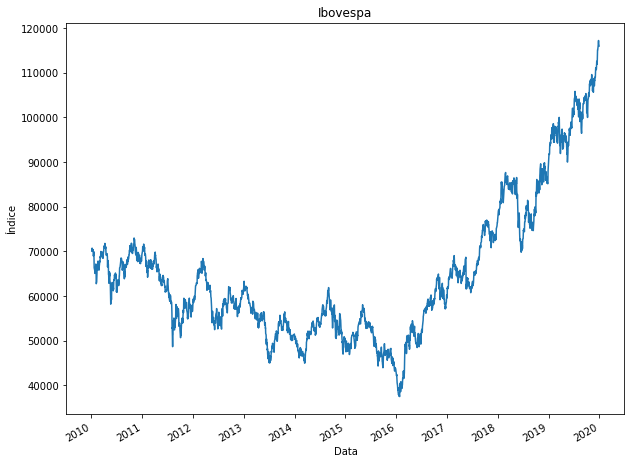

In [13]:
# Carregando Pacotes
from ctypes import cast
import pandas as pd
import numpy as np
import pandas_datareader as pnd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as st

# Coletando índice do Ibovespa
ibov = pnd.get_data_yahoo("^BVSP", start = '01-01-2010', end = '01/01/2020')
total = pnd.get_data_yahoo("^BVSP", start = '01-01-2010')
print(ibov.tail(5))

# Constuindo gráfico do índice
ibov["Close"].plot(figsize = (10,8))
plt.title('Ibovespa')
plt.ylabel('Índice')
plt.xlabel('Data')
plt.show()

Observamos, portanto, que o índice não tem tantas oscilações bruscas até o final de 2019, fato que não seria verificado nos anos seguintes. Para prosseguir a análise, calculamos o retorno diário do índice no período.

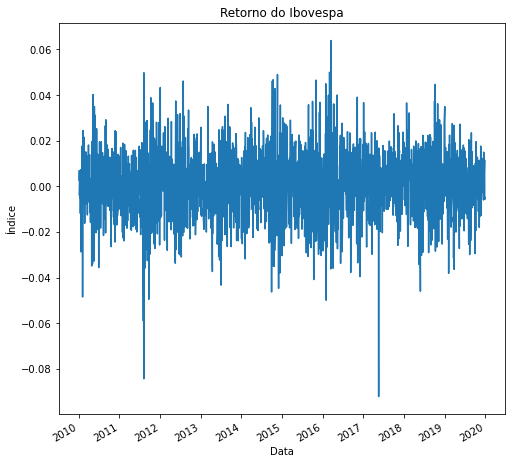

count    2470.000000
mean        0.000204
std         0.014074
min        -0.092107
25%        -0.008099
50%         0.000274
75%         0.008594
max         0.063887
Name: Return, dtype: float64

In [14]:
# Calculando os retornos diários
ibov['Return'] = np.log(ibov.Close)-np.log(ibov.Close.shift(1))
ibov = ibov.iloc[1:]
total = total.iloc[1:]
ibov["Return"].plot(figsize = (10,8))
plt.title('Retorno do Ibovespa')
plt.ylabel('Índice')
plt.xlabel('Data')
plt.show()
ibov.Return.describe()

Novamente os retornos seguem relativamente constantes, com média 0,0206%, desvio padrão de 1,41%. Definimos, apriori, em função da postagem anterior, que os retornos semguem distribuição t, confirmado teste Kolmogorov-Smirnov.

Parâmetros: (7.037899670866842, 0.0002553948973005612, 0.011909751305119197)
KstestResult(statistic=0.012250328571394409, pvalue=0.8478081503720183)


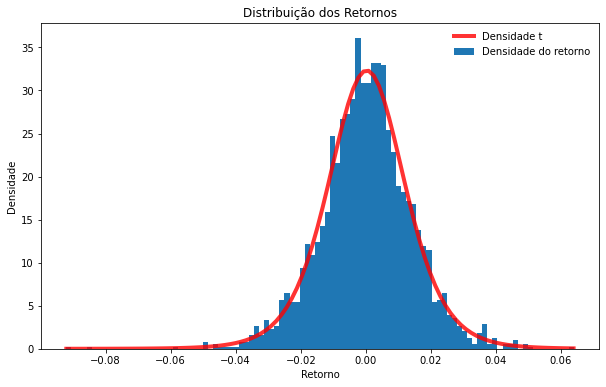

In [15]:
# Analisando similaridade
from scipy.stats import t
dist = getattr(st, 't')
param = dist.fit(ibov['Return'])
print('Parâmetros: ' + str(param))
print(st.kstest(ibov['Return'], 't', args=param))
x = np.linspace(np.percentile(ibov['Return'],0), np.percentile(ibov['Return'],100), 100)
fig, graf = plt.subplots(figsize=(10,6))
graf.plot(x, t.pdf(x, df = param[0], loc = param[1], scale = param[2]),'red', lw=4, alpha = 0.8, label='Densidade t')
graf.hist(ibov['Return'], density=True, histtype='stepfilled', bins = 100, label='Densidade do retorno')
graf.legend(loc='best', frameon=False)
graf.set_title('Distribuição dos Retornos')
graf.set_ylabel('Densidade')
graf.set_xlabel('Retorno')
plt.show()

Então geramos as simulações supondo que os retornos seguem distribuição t, com os parâmetros descritos acima. É gerado 100 mil simulações em um período de 1 ano. Plota-se uma amostra de 20 das 100 mil simulações.

<function matplotlib.pyplot.show(close=None, block=None)>

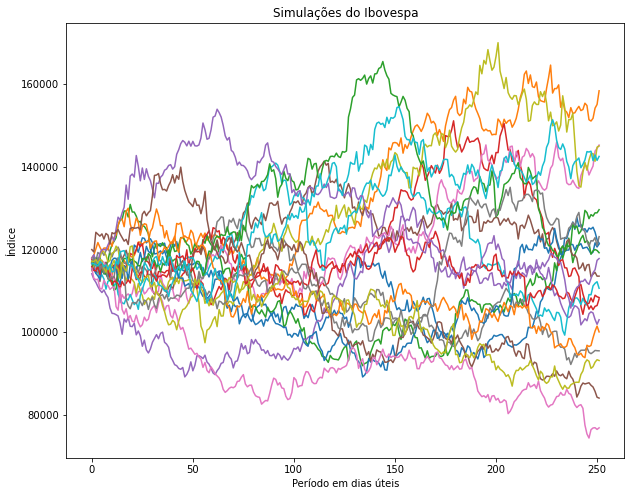

In [16]:
# Gerando matrizes aleatórias
simulacao = np.zeros((252,100000), dtype=np.float64)
for i in range(0,100000):
    simulacao[:,i] = t.rvs(df = param[0], loc = param[1], scale = param[2], size = 252)

# Construindo simulações
simulacao = pd.DataFrame(simulacao)
inicial = ibov.Close.tail(1)
simulacao.iloc[0] = inicial.iloc[0]*(1+simulacao.iloc[0])
for i in range(1,len(simulacao)):
    simulacao
    j = i-1
    simulacao.iloc[i] = simulacao.iloc[j]*(1+simulacao.iloc[i])

# Plotando gráfico das 1000 primeiras simulações
fig = plt.figure(figsize = (10,8))
plt.plot(simulacao.iloc[:,0:20])
plt.title('Simulações do Ibovespa')
plt.ylabel('Índice')
plt.xlabel('Período em dias úteis')
plt.show

Cada simulação representa uma situação possível do Ibovespa caso os retornos sigam o mesmo padrão. Então, contruímos os cenários com uma análise dos percentis das simulações.

## Construção de cenário
Vamos avaliar em 4 situações diferentes. Primeiro, removendo 10% dos outliers (valores extremos), por conseguinte vai ser removido 5% dos outliers, posteriormente somente 1% dos outliers serão descartados, e por ultimo utiliza-se todas as simulações. 

Como métrica de análise vai ser utilizada a amplitude total dos cenários no final do período, % do tempo que o índice ficou dentro do intervalo de algumas dos cenários, e por ultimo % do tempo que o índice ficou fora do intervalo.

A respeito da amplitude, melhor será quanto menor for o valor. A segunda métrica será melhor na medida que maior for valor, e a última será melhor quanto mais próximo de zero for.

### Removendo 10% dos outliers

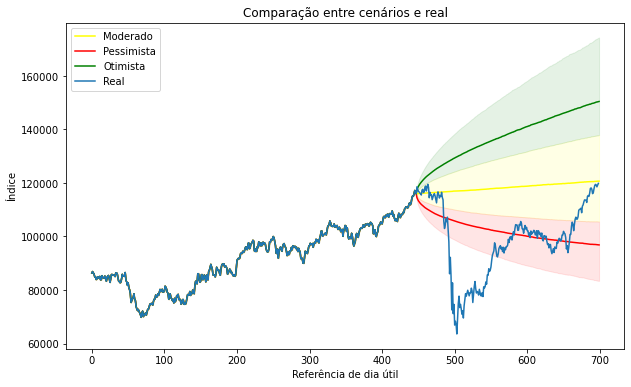

In [18]:
# Outliers que serão removidos
alpha = 10 

# Cálculo dos limites
sss = 100-alpha/2
ppp = 0+alpha/2
mmm = (sss+ppp)/2
p = (mmm+ppp)/2
pp = (p+ppp)/2
s = (mmm+sss)/2
ss = (s+sss)/2

# Coletando cenários
import warnings
warnings.filterwarnings('ignore')
sim_results = []
for i in range(0,len(simulacao)):
    min = np.percentile(simulacao.iloc[i], ppp)
    pessim = np.percentile(simulacao.iloc[i], pp)
    lim1 = np.percentile(simulacao.iloc[i], p)
    mod = np.percentile(simulacao.iloc[i], mmm)
    lim2 = np.percentile(simulacao.iloc[i], s)
    otim = np.percentile(simulacao.iloc[i], ss)
    sup = np.percentile(simulacao.iloc[i], sss)
    sim_results.append((min, pessim, lim1, mod, lim2, otim, sup))
sim_results = pd.DataFrame(sim_results)

# Sumarizando Dataframe
dados = pd.DataFrame(ibov['Close'].append(sim_results.iloc[:,0]))
for i in range(1,7):
    dados[i] = pd.DataFrame(ibov['Close'].append(sim_results.iloc[:,i]))
dados = dados.rename(columns={0:'Minimo', 1:"Pessimista", 2:"lim1", 
3:'Moderado', 4:'lim2', 5:"Otimista", 6:"Superior"})
dados = dados.reset_index(drop=True)

# Adicionando observações atuais
merge = pd.DataFrame(total["Close"].iloc[0:2722])
merge = merge.reset_index(drop = True)
dados["Real"] = merge

# Montando gráfico
graf = dados.iloc[(len(dados)-700):len(dados),]
graf = graf.reset_index(drop=True)
graf = graf.reset_index()
fig, grf = plt.subplots(figsize=(10,6))
grf.plot(graf['index'], graf['Moderado'], color = 'yellow', label = 'Moderado')
grf.fill_between(graf['index'],graf['lim1'],graf['lim2'], color='yellow', alpha=.1)
grf.plot(graf['index'], graf['Pessimista'], color = 'red', label = 'Pessimista')
grf.fill_between(graf['index'],graf['Minimo'],graf['lim1'], color='red', alpha=.1)
grf.plot(graf['index'], graf['Otimista'], color = 'green', label = 'Otimista')
grf.fill_between(graf['index'],graf['lim2'],graf['Superior'], color='green', alpha=.1)
grf.plot(graf['index'], graf['Real'], label = 'Real')
grf.set_title('Comparação entre cenários e real')
grf.set_ylabel('Índice')
grf.set_xlabel('Referência de dia útil')
grf.legend(loc = 'upper left')
plt.show()

Notamos, portanto, que teve um período em que o índice ficou abaixo do cenário pessimista, mas logo em seguida retorna a média indo para o cenário moderado.

A amplitude total é de 53 mil, e o índice ficou 24% do tempo fora do intervado e 76% dentro do intervalo.

### Removendo 5% dos Outliers

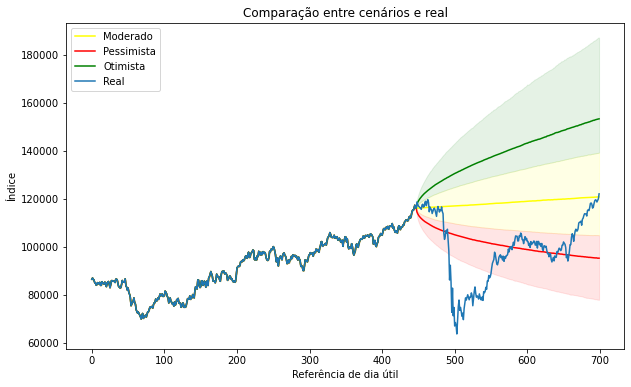

In [23]:
# Outliers que serão removidos
alpha = 5

# Cálculo dos limites
sss = 100-alpha/2
ppp = 0+alpha/2
mmm = (sss+ppp)/2
p = (mmm+ppp)/2
pp = (p+ppp)/2
s = (mmm+sss)/2
ss = (s+sss)/2

# Coletando cenários
import warnings
warnings.filterwarnings('ignore')
sim_results = []
for i in range(0,len(simulacao)):
    min = np.percentile(simulacao.iloc[i], ppp)
    pessim = np.percentile(simulacao.iloc[i], pp)
    lim1 = np.percentile(simulacao.iloc[i], p)
    mod = np.percentile(simulacao.iloc[i], mmm)
    lim2 = np.percentile(simulacao.iloc[i], s)
    otim = np.percentile(simulacao.iloc[i], ss)
    sup = np.percentile(simulacao.iloc[i], sss)
    sim_results.append((min, pessim, lim1, mod, lim2, otim, sup))
sim_results = pd.DataFrame(sim_results)

# Sumarizando Dataframe
dados = pd.DataFrame(ibov['Close'].append(sim_results.iloc[:,0]))
for i in range(1,7):
    dados[i] = pd.DataFrame(ibov['Close'].append(sim_results.iloc[:,i]))
dados = dados.rename(columns={0:'Minimo', 1:"Pessimista", 2:"lim1", 
3:'Moderado', 4:'lim2', 5:"Otimista", 6:"Superior"})
dados = dados.reset_index(drop=True)

# Adicionando observações atuais
merge = pd.DataFrame(total["Close"].iloc[0:2722])
merge = merge.reset_index(drop = True)
dados["Real"] = merge

# Montando gráfico
graf = dados.iloc[(len(dados)-700):len(dados),]
graf = graf.reset_index(drop=True)
graf = graf.reset_index()
fig, grf = plt.subplots(figsize=(10,6))
grf.plot(graf['index'], graf['Moderado'], color = 'yellow', label = 'Moderado')
grf.fill_between(graf['index'],graf['lim1'],graf['lim2'], color='yellow', alpha=.1)
grf.plot(graf['index'], graf['Pessimista'], color = 'red', label = 'Pessimista')
grf.fill_between(graf['index'],graf['Minimo'],graf['lim1'], color='red', alpha=.1)
grf.plot(graf['index'], graf['Otimista'], color = 'green', label = 'Otimista')
grf.fill_between(graf['index'],graf['lim2'],graf['Superior'], color='green', alpha=.1)
grf.plot(graf['index'], graf['Real'], label = 'Real')
grf.set_title('Comparação entre cenários e real')
grf.set_ylabel('Índice')
grf.set_xlabel('Referência de dia útil')
grf.legend(loc = 'upper left')
plt.show()

O comportamento é similar ao analisado anteriormente. No entanto, as estatísticas agora registram: Amplitude total de 58 mil, e o índice ficou 23% do tempo fora do intervado e 77% dentro do intervalo. Pouca melhora comparada a remoção de 10% do outlier.

### Removendo 1% dos outliers

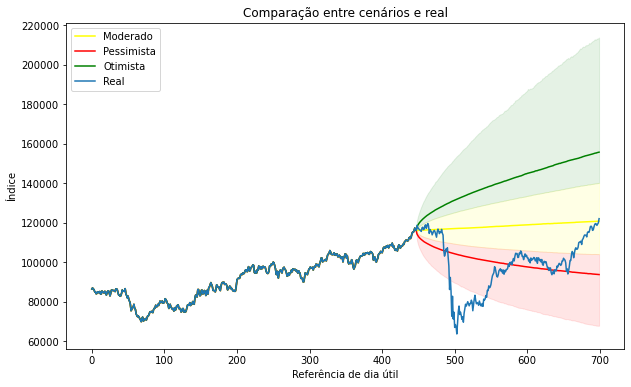

In [26]:
# Outliers que serão removidos
alpha = 1

# Cálculo dos limites
sss = 100-alpha/2
ppp = 0+alpha/2
mmm = (sss+ppp)/2
p = (mmm+ppp)/2
pp = (p+ppp)/2
s = (mmm+sss)/2
ss = (s+sss)/2

# Coletando cenários
import warnings
warnings.filterwarnings('ignore')
sim_results = []
for i in range(0,len(simulacao)):
    min = np.percentile(simulacao.iloc[i], ppp)
    pessim = np.percentile(simulacao.iloc[i], pp)
    lim1 = np.percentile(simulacao.iloc[i], p)
    mod = np.percentile(simulacao.iloc[i], mmm)
    lim2 = np.percentile(simulacao.iloc[i], s)
    otim = np.percentile(simulacao.iloc[i], ss)
    sup = np.percentile(simulacao.iloc[i], sss)
    sim_results.append((min, pessim, lim1, mod, lim2, otim, sup))
sim_results = pd.DataFrame(sim_results)

# Sumarizando Dataframe
dados = pd.DataFrame(ibov['Close'].append(sim_results.iloc[:,0]))
for i in range(1,7):
    dados[i] = pd.DataFrame(ibov['Close'].append(sim_results.iloc[:,i]))
dados = dados.rename(columns={0:'Minimo', 1:"Pessimista", 2:"lim1", 
3:'Moderado', 4:'lim2', 5:"Otimista", 6:"Superior"})
dados = dados.reset_index(drop=True)

# Adicionando observações atuais
merge = pd.DataFrame(total["Close"].iloc[0:2722])
merge = merge.reset_index(drop = True)
dados["Real"] = merge

# Montando gráfico
graf = dados.iloc[(len(dados)-700):len(dados),]
graf = graf.reset_index(drop=True)
graf = graf.reset_index()
fig, grf = plt.subplots(figsize=(10,6))
grf.plot(graf['index'], graf['Moderado'], color = 'yellow', label = 'Moderado')
grf.fill_between(graf['index'],graf['lim1'],graf['lim2'], color='yellow', alpha=.1)
grf.plot(graf['index'], graf['Pessimista'], color = 'red', label = 'Pessimista')
grf.fill_between(graf['index'],graf['Minimo'],graf['lim1'], color='red', alpha=.1)
grf.plot(graf['index'], graf['Otimista'], color = 'green', label = 'Otimista')
grf.fill_between(graf['index'],graf['lim2'],graf['Superior'], color='green', alpha=.1)
grf.plot(graf['index'], graf['Real'], label = 'Real')
grf.set_title('Comparação entre cenários e real')
grf.set_ylabel('Índice')
grf.set_xlabel('Referência de dia útil')
grf.legend(loc = 'upper left')
plt.show()

Neste caso a melhoria da qualidade dos cenários foi mais expressiva. A amplitude foi de 61 mil pontos, e somente 20% do tempo o índice ficou fora do intervalo ante 24% da situação anterior.

### Todas as simulações

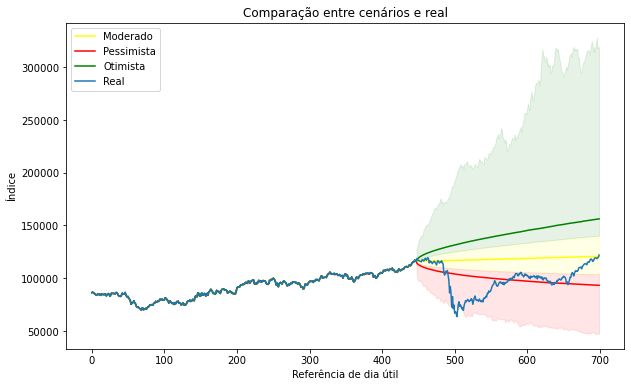

In [28]:
# Outliers que serão removidos
alpha = 0

# Cálculo dos limites
sss = 100-alpha/2
ppp = 0+alpha/2
mmm = (sss+ppp)/2
p = (mmm+ppp)/2
pp = (p+ppp)/2
s = (mmm+sss)/2
ss = (s+sss)/2

# Coletando cenários
import warnings
warnings.filterwarnings('ignore')
sim_results = []
for i in range(0,len(simulacao)):
    min = np.percentile(simulacao.iloc[i], ppp)
    pessim = np.percentile(simulacao.iloc[i], pp)
    lim1 = np.percentile(simulacao.iloc[i], p)
    mod = np.percentile(simulacao.iloc[i], mmm)
    lim2 = np.percentile(simulacao.iloc[i], s)
    otim = np.percentile(simulacao.iloc[i], ss)
    sup = np.percentile(simulacao.iloc[i], sss)
    sim_results.append((min, pessim, lim1, mod, lim2, otim, sup))
sim_results = pd.DataFrame(sim_results)

# Sumarizando Dataframe
dados = pd.DataFrame(ibov['Close'].append(sim_results.iloc[:,0]))
for i in range(1,7):
    dados[i] = pd.DataFrame(ibov['Close'].append(sim_results.iloc[:,i]))
dados = dados.rename(columns={0:'Minimo', 1:"Pessimista", 2:"lim1", 
3:'Moderado', 4:'lim2', 5:"Otimista", 6:"Superior"})
dados = dados.reset_index(drop=True)

# Adicionando observações atuais
merge = pd.DataFrame(total["Close"].iloc[0:2722])
merge = merge.reset_index(drop = True)
dados["Real"] = merge

# Montando gráfico
graf = dados.iloc[(len(dados)-700):len(dados),]
graf = graf.reset_index(drop=True)
graf = graf.reset_index()
fig, grf = plt.subplots(figsize=(10,6))
grf.plot(graf['index'], graf['Moderado'], color = 'yellow', label = 'Moderado')
grf.fill_between(graf['index'],graf['lim1'],graf['lim2'], color='yellow', alpha=.1)
grf.plot(graf['index'], graf['Pessimista'], color = 'red', label = 'Pessimista')
grf.fill_between(graf['index'],graf['Minimo'],graf['lim1'], color='red', alpha=.1)
grf.plot(graf['index'], graf['Otimista'], color = 'green', label = 'Otimista')
grf.fill_between(graf['index'],graf['lim2'],graf['Superior'], color='green', alpha=.1)
grf.plot(graf['index'], graf['Real'], label = 'Real')
grf.set_title('Comparação entre cenários e real')
grf.set_ylabel('Índice')
grf.set_xlabel('Referência de dia útil')
grf.legend(loc = 'upper left')
plt.show()

Utilizando todas as simulações, a amplitude entre o cenário pessimista e otimista é de 63 mil, mas a amplitude entre o cenário mínimo e o máximo é muito elevado. Neste caso o índice fica dentro do intevalo em 97% do tempo.

## Considerações Finais
Os cenários feitos com simulações de Monte Carlo supondo distribuição t tende a ter maioria das observações dentro do intervalo mesmo com ambiente econômico instável. Além disso, através de uma observação do gráfico, o índice tende a retornar a média no médio prazo após momentos de maiores oscilações.